# Few learnings on preparing data for machine learnign algorithms

Training data plays a key role in deciding the quality of predictisons of the trained model, here are few basic learnings I had about preparing the training data that for one of my first ML competition on HackerEarth.

__Problem statement:__

Ad click prediciton based on user history on various parameters like Device, Browser, Location, Ad category, Site, Offer type etc given a training set of historical events of ads shown to user wheather the ad was clicked or not along with timestamps.


__Let's see how data looks like:__

In [5]:
setwd("~/pgms/ml/he3") #This is my local dir
library("readr")
data <- read_csv("train.csv")
head(data)

Parsed with column specification:
cols(
  ID = col_character(),
  datetime = col_datetime(format = ""),
  siteid = col_integer(),
  offerid = col_integer(),
  category = col_integer(),
  merchant = col_integer(),
  countrycode = col_character(),
  browserid = col_character(),
  devid = col_character(),
  click = col_integer()
)


ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,click
IDsrk7SoW,2017-01-14 09:42:09,4709696,887235,17714,20301556,e,Firefox,NA,0
IDmMSxHur,2017-01-18 17:50:53,5189467,178235,21407,9434818,b,Mozilla Firefox,Desktop,0
IDVLNN0Ut,2017-01-11 12:46:49,98480,518539,25085,2050923,a,Edge,NA,0
ID32T6wwQ,2017-01-17 10:18:43,8896401,390352,40339,72089744,c,Firefox,Mobile,0
IDqUShzMg,2017-01-14 16:02:33,5635120,472937,12052,39507200,d,Mozilla Firefox,Desktop,0
IDjO9XQ1Z,2017-01-14 12:08:49,2729292,961176,33638,47079934,e,Google Chrome,Mobile,0


__Let's see the data size:__

In [7]:
dim(data)

[1] 12137810       10

## Lesson 1: Have the data distrubuted uniformly over all classes in training set

How do we go about choosing a training set and validation set? 

One very common way is to randomly choose 60% of data for training and 40% for validation - this mught work in most cases, but we need to be cautious of the data set we are handling, lets see why this strategy does not work for us and what us the best strategy.

In [8]:
set.seed(42)
select <- sample(2, nrow(data), replace = T, prob=c(0.6,0.4))
train <- data[select == 1,]
validate <- data[select == 2,]

__Let's analyse how our training set is distributed.__

In [9]:
click_dist <- table(data$click)
as.data.frame(click_dist)

Var1,Freq
0,11700596
1,437214


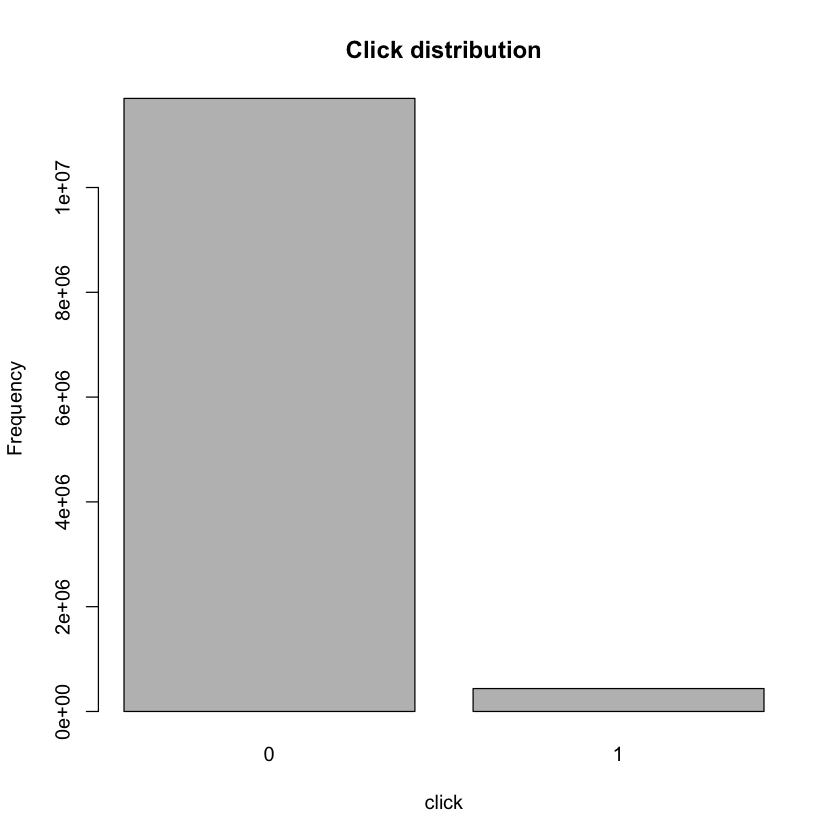

In [39]:
barplot(click_dist, main="Click distribution", xlab="click", ylab="Frequency")

The training set heavily skewed, it contains extremely small number of observations for `click=1` what this means is if we train a model to predict click based on this training set. Irrespective of the algorithm we choose to build our prediction model, the model can choose to always say "click = 0", because of a simple fact that within the training set, always predicting click=0 will give a pretty high accuracy score.

In [10]:
#accuracy
click_dist[1] / (click_dist[1] + click_dist[2])

0 
0.9639792

__Conclusion__:
* Make sure your data is distrubuted evenly across all the classes if you are training a classifier, 
* More than this, the bigger lesson here is, it is important to understand the data we are using and select a meaningful training set 
* + For example if you are building a regression model to predict someting over the same data, say user-engangement-time - and let say you initially had a weeks worth of data - it makes more sense evenly choose 60% of data from all days of the week rather then say using first 4 days of data as training set - this way we capture the user behaviour on weekdays and weekends
* + Where as if the same data was for weather prediction (temperatire) it doesn't matter weekdays or weekends (Moths matter there!)

## Lesson 2: Have an eye for hidden info

More often than not, the data set has very insightful info but not very apparent. Sometimes you need to know what you are searching for already and then you might surprisingly find ways to dig out that information from the data.

In the current problem, I was trying to fit a decision tree / random forest to predict the ad click. My intuition was people click on ads more during the evenings than in days because you are at work during the day time (I might be wrong as well but this was something I wanted to check) - Also the time varies across the globe and I had to use some timezone info to come up with my new time category for DAY/EVENING/NIGHT etc

One easy way to achieve this was to use ```hour of the day```, ```day of the week``` and ```country code``` as categorical variables - the combination of which will generate 24 classes of time of day and also the contry code helps handling the timezone varioation and day of week adds any bias related to weekend vs/weekday. 

Note that the timestams are all in UTC and the day we generate might not be the day in a given country - but we will not be off by more than an hour if you think about it!

In fact it turned out that country code / hour as primary variables in splitting the nodes at initial level once the decision tree was generated.

In [17]:
hours <- format(head(data$datetime), "%H")  #Extract hours
hours

[1] "09" "17" "12" "10" "16" "12"

In [18]:
weekday <- format(head(data$datetime), "%A")  #Extract weekday
weekday

[1] "Saturday"  "Wednesday" "Wednesday" "Tuesday"   "Saturday"  "Saturday"

In [30]:
cbind(head(data), hours, weekday)

ID,datetime,siteid,offerid,category,merchant,countrycode,browserid,devid,click,hours,weekday
IDsrk7SoW,2017-01-14 09:42:09,4709696,887235,17714,20301556,e,Firefox,NA,0,09,Saturday
IDmMSxHur,2017-01-18 17:50:53,5189467,178235,21407,9434818,b,Mozilla Firefox,Desktop,0,17,Wednesday
IDVLNN0Ut,2017-01-11 12:46:49,98480,518539,25085,2050923,a,Edge,NA,0,12,Wednesday
ID32T6wwQ,2017-01-17 10:18:43,8896401,390352,40339,72089744,c,Firefox,Mobile,0,10,Tuesday
IDqUShzMg,2017-01-14 16:02:33,5635120,472937,12052,39507200,d,Mozilla Firefox,Desktop,0,16,Saturday
IDjO9XQ1Z,2017-01-14 12:08:49,2729292,961176,33638,47079934,e,Google Chrome,Mobile,0,12,Saturday


## Lesson 3 : Converting from numerical to Categorical variables

The concept is pretty straight forward, take a numerical feature, split into n ranges and treat each segment of the range as a category.

Example : Age : 0-4, 4 - 12, 13 - 19, 20-30, 30+  for identifying various customer segment

The problem here is, the same field can be segmented into multiple ways. which one is the right option?

Like always, the understanding of the data at hand and problem we are trying to sovle should give the first level of hint. If you are analysing data of a movie rating system may be a segmentations for kids, teens and adults might suffice, but for a medical diagnostic you might want a fine grain segmentation ex: new borns, kids, teens, adult, old etc .. 

Sometimes the data does not have any particular meaning to forma a range - example : in our data set ```merchantcode``` - merchant code 1 is in no way comparable to merchant code 2 - in a sense it is alreayd categorical variable - but how do we get a better info in such situations.

Let's see some info on merchant code

In [38]:
length(unique(data$merchant))  # Total number of unique merchants

[1] 697

In [39]:
nrow(data) # Total number of observations

[1] 12137810

In [40]:
nrow(data) / length(unique(data$merchant))  # Average observations per merchant

[1] 17414.36

Even if we decide to use 697 levels for a feture in a dataset of 12 mn observations - it still sounds fair. But this is not always the case - sometimes we might have few thousands of levels, if the cardinality is pretty high we might want to reduce the number of levels in our categorical variable.

Let's say we want to get down to a managable number of levels ( R's party package for creating decision tree cannot handle features with more than 20 levels - or some low number if I remember correctly)

Also another motivation for me to process this data was, since this was a competition problem, I also had test set - and I found that the same merchant id was present in test set as well, so I wanted to make use of some inforamtion from training set.

__Strategy:__
Find the percentage of click for each merchant then categorize them by segments in percentage of click.

In [49]:
merchants <- data.frame(rbind(table(data$merchant, data$click)))
merchants$click_pct <- merchants$X1 / (merchants$X1 + merchants$X0)
head(merchants)

,X0,X1,click_pct
260443,3893,310,0.07375684
555603,219103,10393,0.04528619
628001,78,23,0.22772277
1042419,21,10,0.32258065
1064733,4972,1319,0.20966460
1084693,5169,408,0.07315761


Now we are ready to split the ```click_pct``` into multiple segments - If we use a naive splitting strategy it might not work out well for all cases. Let's see what happens with a naive splitting logic.

Example split data in classes for 0-10% click, 10-20%, .... 90-100% - which sounds like a fair strategy.

In [52]:

splits = seq(from=0,to=1,by=0.1)
splits[1] = -1
merchants$catTypeA <- cut(merchants$click_pct, breaks = splits, labels = 1:10)

head(merchants)

,X0,X1,click_pct,catTypeA
260443,3893,310,0.07375684,1
555603,219103,10393,0.04528619,1
628001,78,23,0.22772277,3
1042419,21,10,0.32258065,4
1064733,4972,1319,0.20966460,3
1084693,5169,408,0.07315761,1


Cool! We have successfully used merchant id info to add a categorical variable of just 10 levels, but is that really useful? Lets see how the catTypeA info looks like.

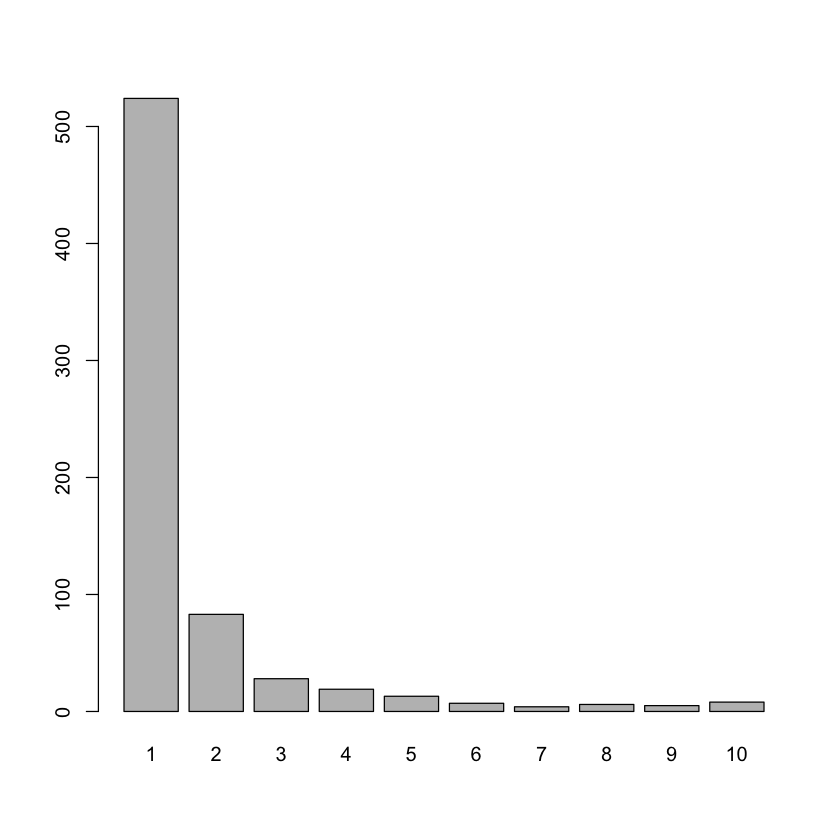

In [57]:
barplot(table(merchants$catTypeA))

Well, significant number of merchants have a click_pct < 20% - while this categorical split may help in few models for a decision tree, it is better to have a more event split category which gives the algorithm an option to split data in better ways.

In [69]:
merchants$catTypeB <- cut(merchants$click_pct, breaks = c(-0.01, 0.01, 0.02, 0.03, 0.04, 0.05,0.06, 0.07, 0.08, 0.2, 1), labels = 1:10)

In [59]:
head(merchants)

,X0,X1,click_pct,catTypeA,catTypeB
260443,3893,310,0.07375684,1,8
555603,219103,10393,0.04528619,1,5
628001,78,23,0.22772277,3,10
1042419,21,10,0.32258065,4,10
1064733,4972,1319,0.20966460,3,10
1084693,5169,408,0.07315761,1,8


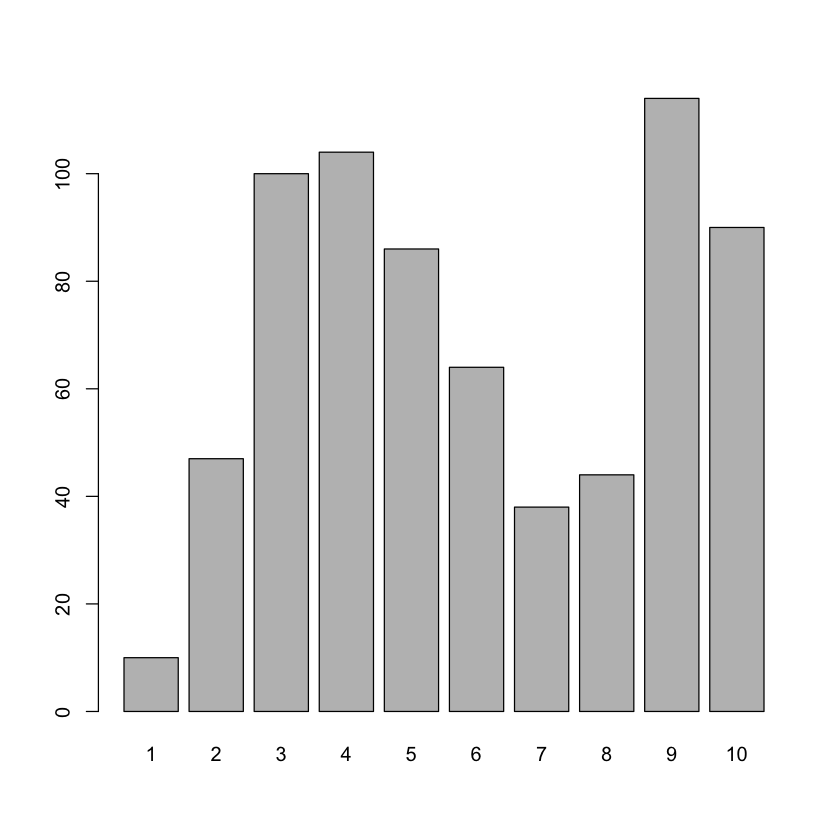

In [70]:
barplot(table(merchants$catTypeB))

In the second segmentaion the splits are more comparably distributed, the accuracy of the decision tree was also imorived on cross validation set in this way.

#### Thank you!

Hope you enjoyed read this, for any comments, likes or pokes - tweet me at ```@manuskc```